In [2]:
import numpy as np
from TimeTagger import *
import matplotlib.pyplot as plt
from IPython.display import clear_output
import serial
import time
import datetime 

In [3]:
# Establish the serial connection
tagger = createTimeTagger()
ser = serial.Serial('COM13', 9600)  # Replace 'COM3' with your Arduino's port
# doesnot print to execute it
print(ser.readline())
print(ser.readline())
print(ser.readline())

b'Demonstration of AccelStepper Library\r\n'
b"Send 'C' for printing the commands.\r\n"
b'Default speed: 400 steps/s, default acceleration: 800 steps/s^2.\r\n'


In [4]:
SPAD_CH = 2 # SPAD Channel
TRIG_CH = 1 # Trigger Channel

# introduce delay in trig channel
delay_hardware = 1.0705e6 # in picosecond
tagger.setInputDelay(1,delay_hardware)

bin_width = 10e-12 # in seconds, check once
c = 3*1e10 #cm

nbins = int(5e-9/bin_width) #5 nanosecond of time data
rep_rate = 10 #1kHz
laser_power = np.round(40 * rep_rate,3) #mW

avg_noise_count = "6000"
# important params: t_acq, bin_width, laser_power

delay = 0.05 #delay between two acquisitions in sec
stepper_speed = 0.1 #cm/sec


#to move 2cm, stepper motor will need 2*6400 steps. at this speed, it will move for 2*64 = 128 seconds lmao
# works ig
xdirection = 1 # 0 for left, 1 for right
ydirection = 0 # 0 for up, 1 for down
#t_acq = npulse/trigfreq #historgram acquisition time
t_acq = 1

delay = t_acq + delay

In [4]:
print(f'Depth resolution: {np.round(bin_width*c,2)} cm')
print(f'Horizontal resolution: {stepper_speed*delay} cm')

# print(f'SPAD_CH: {SPAD_CH}')
# print(f'TRIG_CH: {TRIG_CH}')
# print(f'bin_width: {bin_width*1e12} picoseconds')
# print(f'nbins: {nbins}')
# #print(f'npulse: {npulse}')
# #print(f'trigfreq: {trigfreq} Hz')
# print(f'stepper_speed: {stepper_speed} steps/second')
# print(f'dist_in_cm: {total_distance} cm')
# print(f'number of acq: {n_acq} steps')
print(f't_acq: {t_acq} seconds')

Depth resolution: 0.3 cm
Horizontal resolution: 0.10500000000000001 cm
t_acq: 1 seconds


In [5]:
#Directions are given from the perspective of entering the optical table room in FSLab
def send_command(command):
    ser.write(command.encode())

def right_step(dist,speed):
    send_command(f'R{dist} {speed}')
    print(ser.readline())

def left_step(dist,speed):
    send_command(f'L{dist} {speed}')
    print(ser.readline())

# def x_step(dist, speed):
#     dist*=6400
#     speed*=6400
#     if xdirection.lower() == "up":
#         left_step(dist,speed)
#     elif xdirection.lower() == "down":
#         right_step(dist,speed)
#     else:
#         exit()    

# def y_step(dist, speed):
#     dist*=6400
#     speed*=6400
#     if ydirection.lower() == "left":
#         left_step(dist,speed)
#     elif ydirection.lower() == "right":
#         right_step(dist,speed)
#     else:
#         exit()


def x_step(dist, speed):
    dist*=6400
    speed*=6400
    if xdirection == 0:
        left_step(dist,speed)
    elif xdirection == 1:
        right_step(dist,speed)
    else:
        exit()    

def y_step(dist, speed):
    dist*=6400
    speed*=6400
    if ydirection == 0:
        up_step(dist,speed)
    elif ydirection == 1:
        down_step(dist,speed)
    else:
        exit()

def home_set():
    send_command('X')
    print(ser.readline())


def down_step(dist,speed):
    send_command(f'D{dist} {speed}')
    print(ser.readline())


def up_step(dist,speed):
    send_command(f'U{dist} {speed}')
    print(ser.readline())


def home_step():
    send_command('H')  
    print(ser.readline())
    print(ser.readline())
    print(ser.readline())

def getlocation():
    send_command('E')
    t =  int(ser.readline().split()[-1]), int(ser.readline().split()[-1])
    #print(t)
    return t[0]/6400,t[1]/6400

def hist(t, bin_width, nbins):
    
    global SPAD_CH, TRIG_CH, tagger
    # print('a0) ',time.time())
    bin_width*=1e12
    t*=1e12 #every time data converted to ps
    hist = Histogram(tagger, SPAD_CH, TRIG_CH, bin_width, nbins)
    hist.startFor(t) #60e12 #in ps
    # print('a) ',time.time())
    while hist.isRunning():
        continue
    # print('b) ',time.time())    
    arr = np.array(hist.getData())
#    tt.getOverflowsAndClear()   
    #clear_output(wait=True)     
    # print('c) ',time.time())    
#    plt.plot(range(len(arr)),arr)
#    plt.show()
    # print('d) ',time.time())    
    # print('e) ',time.time())
    return arr # returns x in picosecond

In [6]:
up_step(6400, 6400)

b'Negative direction for Y-axis.\r\n'


In [7]:
down_step(6400, 6400)

b'Positive direction for Y-axis.\r\n'


In [13]:
up_step(6400, 6400)

b'Negative direction for Y-axis.\r\n'


In [10]:
left_step(6400, 6400)

b'Positive direction for X-axis.\r\n'


### 2D Scan

In [29]:
up_step(6400, 6400)

b'Negative direction for Y-axis.\r\n'


In [81]:
right_step(0.5*6400, 6400)

b'Negative direction for X-axis.\r\n'


In [27]:
left_step(18*6400, 6400)

b'Positive direction for X-axis.\r\n'


In [30]:
# 2d code
x_dist = 15 #cm
y_res = 0.25#cm
y_dist = 3 #cm
n_acq = int((x_dist/stepper_speed)/delay) # exact number of acquisitions

num_ysteps = int(y_dist / y_res)

home_set()


start_time = time.time()

time_delay_2d = []
for j in range(num_ysteps):
    x_step(x_dist,stepper_speed)
    time_array = np.arange(delay,delay*n_acq + delay,delay)
    time_delay_1d = []
    for i in range(n_acq):
        # if i%100==0:
        #     print(i)
        while time.time()<=start_time + time_array[i]:
            continue
        
        time_delay_1d.append(hist(t_acq,bin_width,nbins))
    time_delay_2d.append(time_delay_1d)

    while (abs(getlocation()[0]) < x_dist and xdirection) or (getlocation()[0]<0 and not xdirection):
        print(getlocation())
        continue
    y_step(y_res,stepper_speed)

    while (abs(getlocation()[1]) < round(y_res*(j+1) , 3)):
        continue
    xdirection = not(xdirection)
    


home_step()

b'Current positions are updated to 0.\r\n'
b'Negative direction for X-axis.\r\n'
(-14.67234375, 0.0)
(-14.675625, 0.0)
(-14.67875, 0.0)
(-14.68203125, 0.0)
(-14.6853125, 0.0)
(-14.6884375, 0.0)
(-14.69171875, 0.0)
(-14.695, 0.0)
(-14.698125, 0.0)
(-14.70140625, 0.0)
(-14.7046875, 0.0)
(-14.70796875, 0.0)
(-14.71109375, 0.0)
(-14.714375, 0.0)
(-14.71765625, 0.0)
(-14.72078125, 0.0)
(-14.7240625, 0.0)
(-14.72734375, 0.0)
(-14.73046875, 0.0)
(-14.73375, 0.0)
(-14.73703125, 0.0)
(-14.74015625, 0.0)
(-14.7434375, 0.0)
(-14.74671875, 0.0)
(-14.74984375, 0.0)
(-14.753125, 0.0)
(-14.75640625, 0.0)
(-14.75953125, 0.0)
(-14.7628125, 0.0)
(-14.76609375, 0.0)
(-14.769375, 0.0)
(-14.7725, 0.0)
(-14.77578125, 0.0)
(-14.7790625, 0.0)
(-14.7821875, 0.0)
(-14.78546875, 0.0)
(-14.78875, 0.0)
(-14.791875, 0.0)
(-14.79515625, 0.0)
(-14.7984375, 0.0)
(-14.8015625, 0.0)
(-14.80484375, 0.0)
(-14.808125, 0.0)
(-14.81125, 0.0)
(-14.81453125, 0.0)
(-14.8178125, 0.0)
(-14.8209375, 0.0)
(-14.82421875, 0.0)
(-14.8

In [ ]:
down_step(6400, 6400)

In [13]:
left_step(6400,6400)

b'Positive direction for X-axis.\r\n'


In [70]:
for j in range(np.shape(time_delay_2d)[0]):
    np.savetxt(f'text/{stepper_speed}cms-1_{x_dist}cm_{y_dist}cm.txt',time_delay_2d[j])

FileNotFoundError: [Errno 2] No such file or directory: 'text/0.1cms-1_14cm_2cm.txt'

In [ ]:
import scipy.io 
scipy.io.savemat(f'Mat/{stepper_speed}cms-1_{x_dist}cm_{y_dist}cm.mat', {'mydata': time_delay_2d})

In [ ]:
np.shape(time_delay_2d)

In [31]:
time_delay_2d_np = np.array(time_delay_2d)

In [32]:
np.save('time_delay_2d_np6.np',time_delay_2d_np)

In [6]:
cur = hist(2, bin_width, nbins)

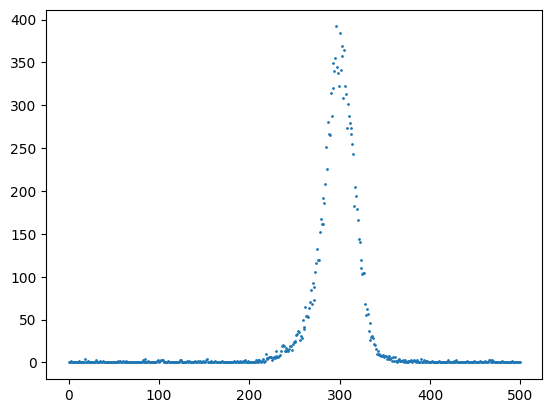

In [9]:
plt.scatter(np.linspace(0,499,500),cur, s=1)

In [74]:
time_delay_2d_np.shape

(4, 133, 500)

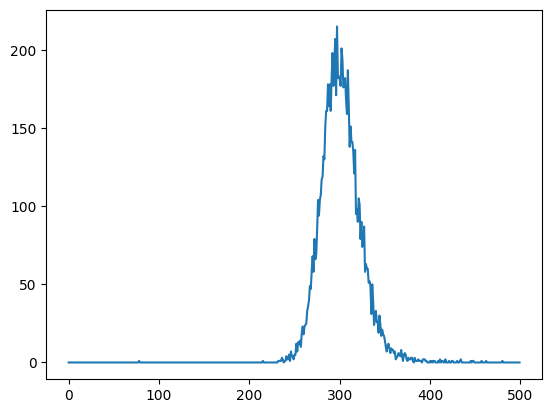

In [73]:
plt.plot(time_delay_2d_np[0,0,:])

In [ ]:
plt.plot(time_delay_2d_np[10,:,100])

In [ ]:
i = 0

while i > 10:
    continue

print(i)

In [ ]:
start_time = time.time()
while time.time() < start_time + 10:
    continue

print(time.time() - start_time)

### 1D Scan

In [19]:
left_step(14*6400, 6400)

b'Positive direction for X-axis.\r\n'


In [14]:
left_step(6400, 6400)

b'Positive direction for X-axis.\r\n'


In [ ]:
up_step(2*6400, 6400)

In [56]:
import numpy as np
import matplotlib.pyplot as plt

In [20]:
x_dist = 18 #cm
n_acq = int((x_dist/stepper_speed)/delay) # exact number of acquisitions
home_set()
start_time = time.time()

x_step(x_dist,stepper_speed)
time_array = np.arange(delay,delay*n_acq + delay,delay)
time_delay_1d = []
for i in range(n_acq):
    # if i%100==0:
    #     print(i)
    while time.time()<=start_time + time_array[i]:
        continue
    
    time_delay_1d.append(hist(t_acq,bin_width,nbins))

b'Current positions are updated to 0.\r\n'
b'Negative direction for X-axis.\r\n'


In [21]:
c = 299792458 #speed of light in m/s
light_10pico = c*(10**-11)*(10**2) #distance travelled by light in 10ps in cm
print(light_10pico)

0.299792458


In [22]:
time_delay_1d = np.array(time_delay_1d)
depth_map = np.zeros(len(time_delay_1d))
for j in range(len(depth_map)):
        m = 0
        t = 0
        for k in range(len(time_delay_1d[0])):
            m+=k*time_delay_1d[j,k]
            t+=time_delay_1d[j,k]
        depth_map[j] = m*light_10pico/t

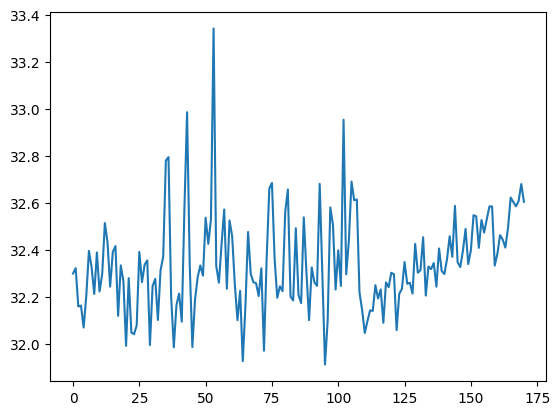

In [26]:
plt.plot(depth_map/3)

In [24]:
np.save('1Dscan2', depth_map)

In [25]:
np.save('1Dscanhist2', time_delay_1d)

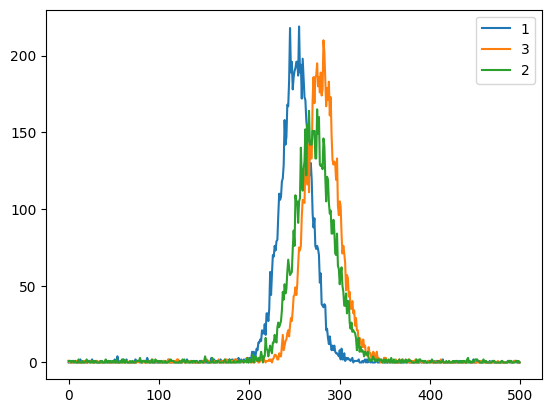

In [73]:
plt.plot(time_delay_1d[1],label="1" )
plt.plot(time_delay_1d[-1],label="3" )
plt.plot(time_delay_1d[-70],label="2" )
plt.legend()
plt.show()


In [28]:
one_point_dist1 = hist(1,bin_width,nbins)

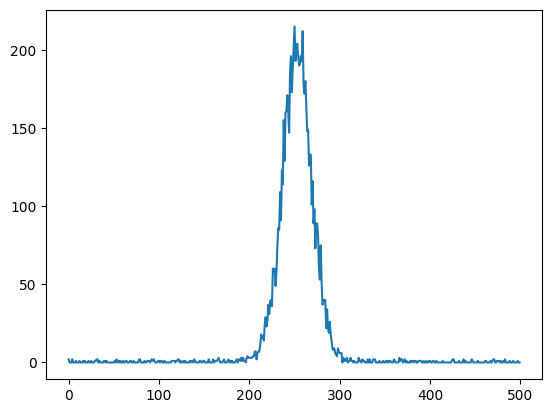

In [29]:
plt.plot(one_point_dist1)

In [36]:
right_step(1*6400,6400)

b'Negative direction for X-axis.\r\n'


In [33]:
one_point_dist2 = hist(1,bin_width,nbins)


In [37]:
one_point_dist3 = hist(1,bin_width,nbins)

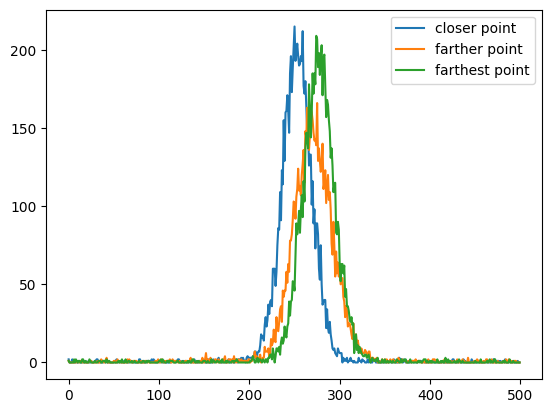

In [39]:
plt.plot(one_point_dist1, label = 'closer point')
plt.plot(one_point_dist2, label = 'farther point')
plt.plot(one_point_dist3, label = 'farthest point')
plt.legend()
plt.show()

In [ ]:
one_point_dist.shape

In [ ]:
np.save('one_point_dist', one_point_dist)

In [5]:
point_hist = []

In [9]:
point_hist.append(hist(1, bin_width, nbins))

### On object histogram

one point is taken from each unique surface of the object to plot the histogram.
left and right are defined from viewer's perspective.
If I am the object my right is the viewers left and vice versa

In [19]:
left_step(2*6400, 6400)

b'Positive direction for X-axis.\r\n'


In [100]:
on_point1 = hist(5,bin_width,nbins)

In [98]:
on_point2 = hist(5,bin_width,nbins)


In [96]:
on_point3 = hist(5,bin_width,nbins)

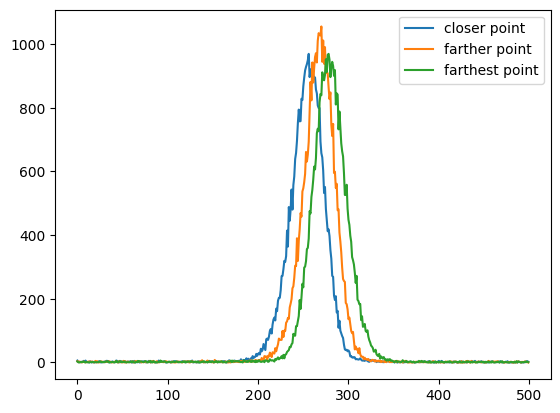

In [99]:
plt.plot(on_point1,label = 'closer point')
plt.plot(on_point2,label = 'farther point')
plt.plot(on_point3,label = 'farthest point')
plt.legend()
plt.show()
at

In [57]:
point_list = []

In [63]:
point_list.append(hist(5,bin_width,nbins))


In [64]:
n=np.array(point_list)
np.save('point_list-Date6-14',n)

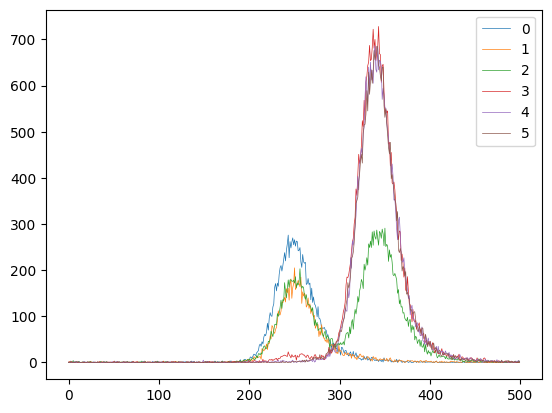

In [65]:
for i in range(0,len(point_list)):
    plt.plot(point_list[i], label = str(i), linewidth=0.5)
    
plt.legend()
plt.show()

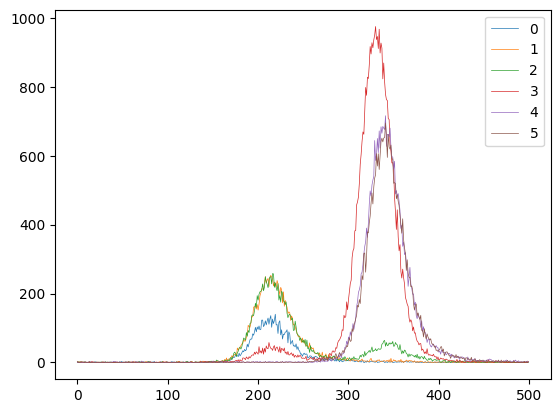

In [56]:
for i in range(0,len(point_list)):
    plt.plot(point_list[i], label = str(i), linewidth=0.5)
    
plt.legend()
plt.show()

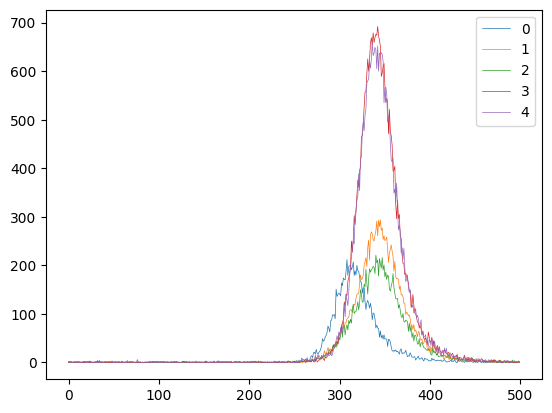

In [46]:
for i in range(0,len(point_list)):
    plt.plot(point_list[i], label = str(i), linewidth=0.5)
    
plt.legend()
plt.show()

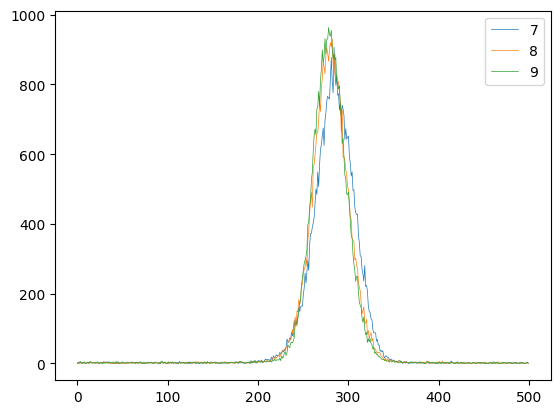

In [121]:
for i in range(5,len(point_list):
    plt.plot(point_list[i], label = str(i), linewidth=0.5)
    
plt.legend()
plt.show()

In [32]:
point_list[0]

92.85062653102904

In [66]:
depth_map = [0]*len(point_list)
time_delay_1d = np.array(point_list.copy())
for j in range(len(depth_map)):
        m = 0
        t = 0
        for k in range(len(time_delay_1d[0])):
            m+=k*time_delay_1d[j,k]
            t+=time_delay_1d[j,k]
        depth_map[j] = m*light_10pico/t

In [67]:
depth_map

[76.10156642537271,
 77.7652259341262,
 93.54560391931075,
 102.21537000790686,
 102.92683156381756,
 102.82139976525815]

In [ ]:
print

In [ ]:
left_step(7*6400, 6400)

In [ ]:
on_point2 =  hist(5,bin_width,nbins)

In [ ]:
plt.plot(on_point2)

In [ ]:
left_step(5*6400, 6400)

In [ ]:
on_point3 =  hist(5,bin_width,nbins)

In [ ]:
plt.plot(on_point3)

In [ ]:
plt.plot(on_point1, label='rightmost')
plt.plot(on_point2, label = 'middle')
plt.plot(on_point3, label = 'leftmost')
plt.legend()
plt.show()

In [ ]:
left_step(4*6400, 3200)

In [ ]:
down_step(4*6400, 6400)

### Wall histogram data

only one point on the left wall.
3 points on the right wall moving increasingly farther from the object.
Left and right are defined from the user perspective when seeng the object straight on

In [ ]:
l_wall = hist(5,bin_width,nbins) #just off the left of the object

In [ ]:
plt.plot(l_wall)

In [ ]:
right_step(16*6400, 6400)

In [ ]:
r_wall1 = hist(5,bin_width,nbins)#just off the object

In [ ]:
plt.plot(r_wall1)
plt.plot(on_point1) # compared with rightmost point on the object

In [ ]:
right_step(2*6400, 6400)

In [ ]:
r_wall2 = hist(5,bin_width,nbins) #2cm off of the object

In [ ]:
plt.plot(r_wall2)
plt.plot(on_point1)

In [ ]:
right_step(2*6400, 6400)

In [ ]:
r_wall3 = hist(5,bin_width,nbins) #4 cm off of the object

In [ ]:
plt.plot(r_wall3)
plt.plot(on_point1)

### Using Proxy

This was done by placing another object exactly where the surface of the original object was

In [ ]:
right_step(5*6400, 6400)

In [ ]:
proxy1 = hist(5,bin_width,nbins) #rightmost

In [ ]:
plt.plot(proxy1)

In [ ]:
proxy2 = hist(5,bin_width,nbins) #middle point

In [ ]:
plt.plot(proxy2)

In [ ]:
proxy3 = hist(5,bin_width,nbins) #leftmost

In [ ]:
plt.plot(proxy3)

In [ ]:
plt.plot(proxy1, label='rightmost')
plt.plot(proxy2, label = 'middle')
plt.plot(proxy3, label = 'leftmost')
plt.legend()
plt.show()

### comparision of on object and proxy

In [ ]:
plt.plot(on_point1, label='onobject')
plt.plot(proxy1, label='proxy')
plt.legend()
plt.show()

In [ ]:
plt.plot(on_point2, label='onobject')
plt.plot(proxy2, label='proxy')
plt.legend()
plt.show()

In [ ]:
plt.plot(on_point3, label='onobject')
plt.plot(proxy3, label='proxy')
plt.legend()
plt.show()

I conclude that something is triggering the spad before the actual reflection from the object when the actual object is placed

When proxy is placed at the forwardmost point of the object

In [ ]:
fm_proxy = hist(5,bin_width,nbins)

compare with the forwardmost point on the object as derived from the experiment, that is the middle surface point

In [ ]:
plt.plot(fm_proxy, label='forwardmost proxy')
plt.plot(on_point2, label='forwardmost object point')
plt.legend()
plt.show()

In [ ]:
plt.plot(fm_proxy, label='forwardmost proxy')
plt.plot(on_point1, label='rightmost')
plt.plot(on_point2, label = 'middle')
plt.plot(on_point3, label = 'leftmost')
plt.legend()
plt.show()

In [ ]:
plt.plot(proxy1, label='onobject')
plt.plot(fm_proxy, label='proxy')
plt.legend()
plt.show()

In [ ]:
! pip install joblib